# Data analysis of NYC4x4 data

# Imports and data loading

In [1]:
import os
os.chdir("..")

In [36]:
import multi_agent_reinforcement_learning
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf

In [37]:
with open("data/scenario_san_francisco.json") as f:
    data = json.loads(f.read())

In [38]:
df = pd.DataFrame(data["demand"])

In [39]:
print(df.shape)
print(df.price.mean())
print(df.price.std())
print(df.price.median())

(5370, 6)
18.69217877094972
8.274623441071
15.7


# Simple summary stats

In [40]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [41]:
df_org_dest.head()

origin destination price           demand travel_time
                     count   mean      mean        mean
0      0           2    15  10.00  0.066667         4.0
1      0           8    15  46.40  0.066667        31.0
2      1           5    15  16.50  0.133333        10.0
3      1           7    30  31.95  0.066667        18.5
4      2           0    15  10.50  0.066667         5.0

In [42]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["org", "dest", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [43]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,1230.296089,6.237430,5.737430,0.385661,11.977654,18.692179
std,51.039938,2.014673,2.372853,0.496670,5.371075,8.274623
min,1140.000000,0.000000,0.000000,0.066667,3.000000,10.000000
25%,1186.000000,5.000000,4.000000,0.066667,9.000000,12.800000
50%,1232.000000,7.000000,6.000000,0.133333,11.000000,15.700000
75%,1273.000000,8.000000,8.000000,0.466667,15.000000,22.700000
max,1319.000000,9.000000,9.000000,2.333333,55.000000,69.400000


# Grid analysis

In [44]:
pivot_df = df_org_dest.pivot(index='org', columns='dest', values='count')

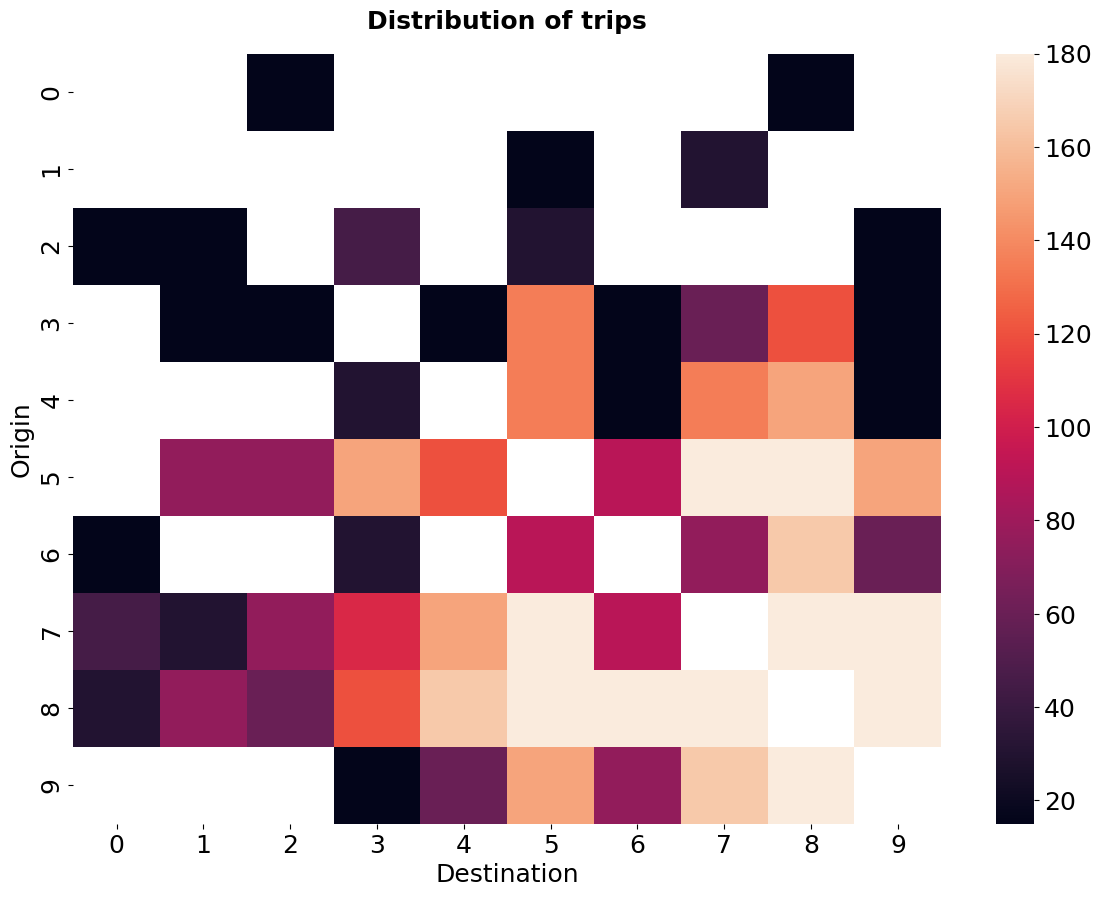

In [45]:
sns.heatmap(pivot_df, annot=False, fmt="d")
plt.title('Distribution of trips')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

In [49]:
#mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(5,5)

In [50]:
#mean_demand_matrix

In [52]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(mean_demand_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
# plt.title('Heatmap of Mean Demand in Each Grid')
# plt.xlabel('Longitude Grid')
# plt.ylabel('Latitude Grid')
# plt.show()

# Travel time analysis

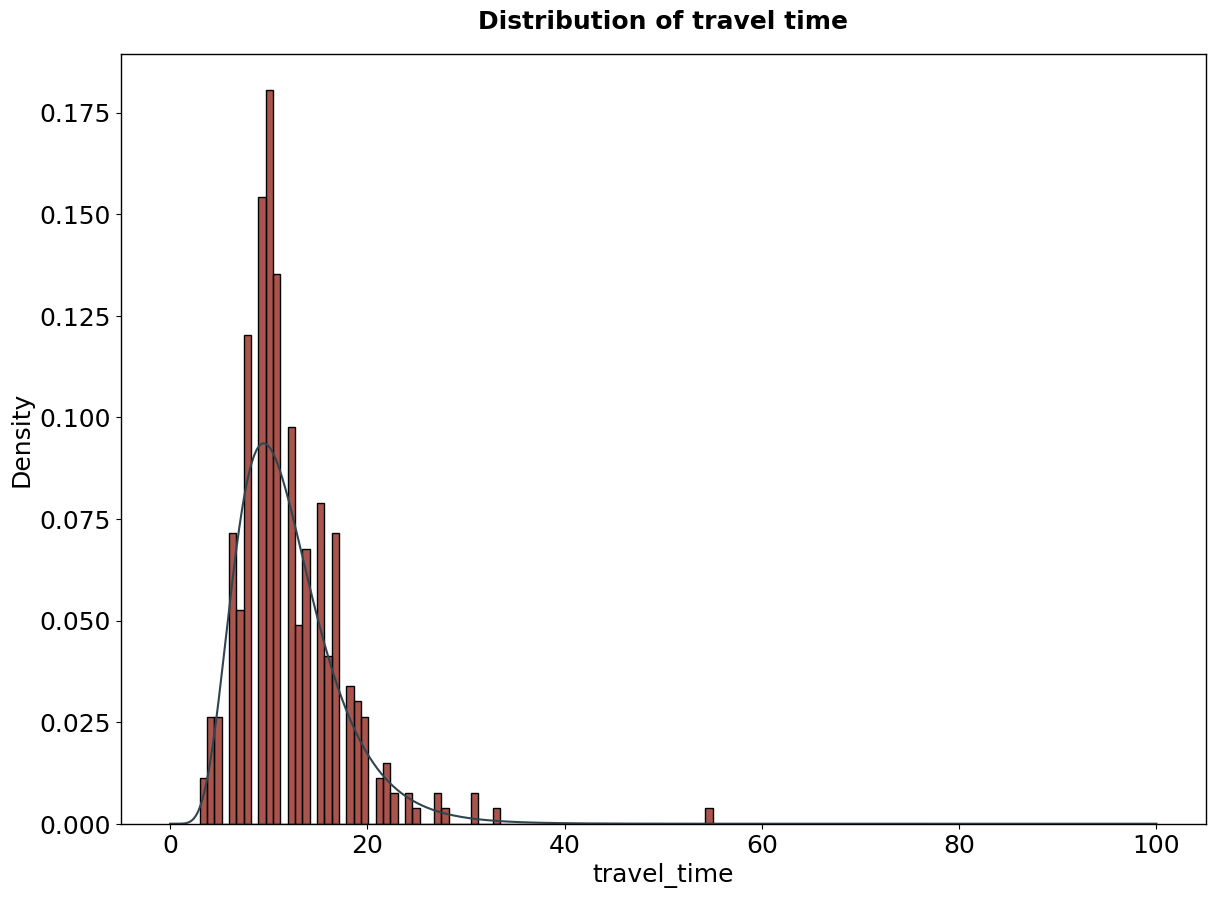

In [56]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density", color="#8C1C13")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of travel time")
plt.show()

# Price analysis

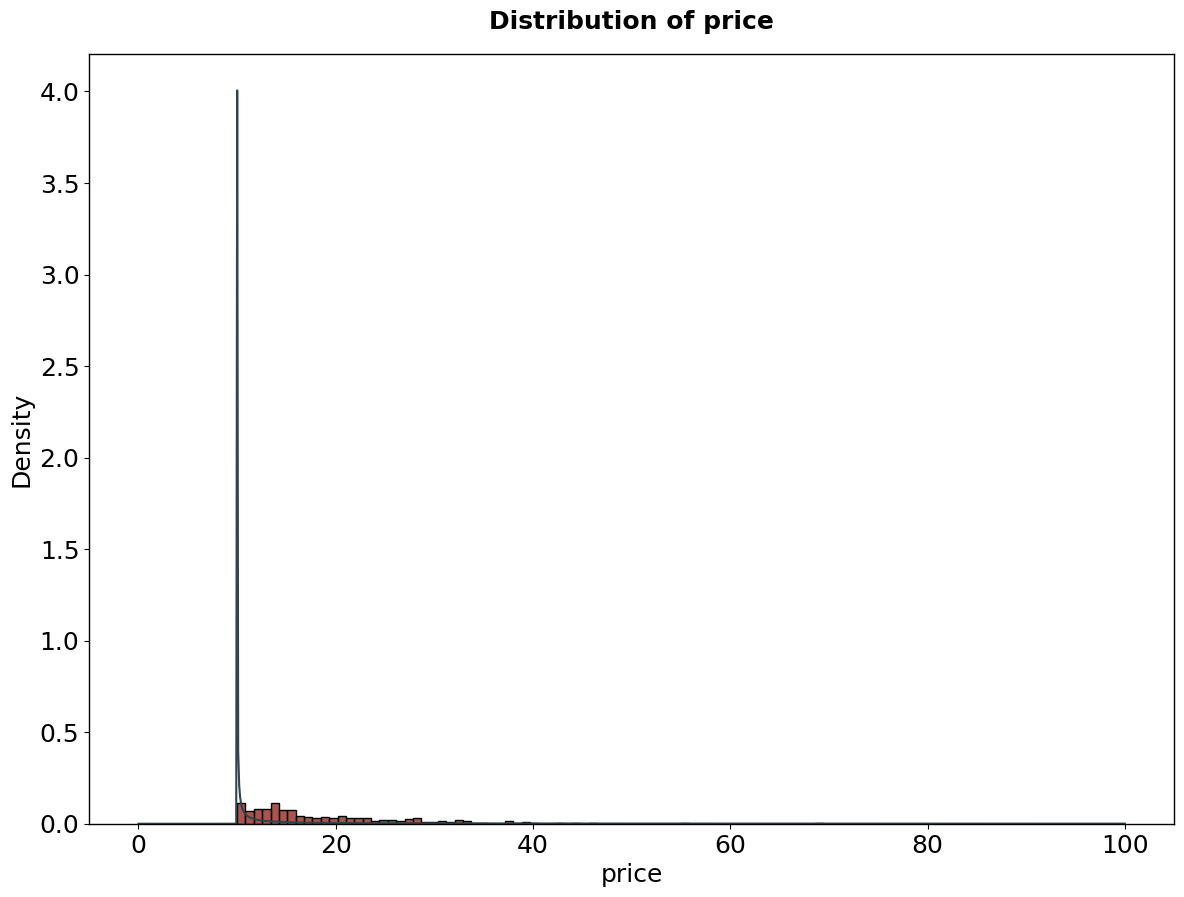

In [57]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of price")
plt.show()

In [21]:
df.head()

,time_stamp,origin,destination,demand,travel_time,price
0,0,5,5,0.6,4.105556,6.5
1,1,5,5,0.6,4.105556,6.5
2,2,5,5,0.6,4.105556,6.5
3,3,5,5,0.6,4.105556,6.5
4,4,5,5,0.6,4.105556,6.5


In [109]:
pred_df = df.copy()

In [151]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [152]:
glm_model = smf.glm(formula="log_price ~ travel_time + demand", data=pred_df, family=sm.families.Gaussian())

In [153]:
fitted_glm = glm_model.fit()

In [154]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              log_price   No. Observations:               281760
Model:                            GLM   Df Residuals:                   281757
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                        0.023548
Method:                          IRLS   Log-Likelihood:             1.2832e+05
Date:                Mon, 25 Sep 2023   Deviance:                       6634.8
Time:                        12:14:54   Pearson chi2:                 6.63e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9211
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7377      0.001   2430.063      0.000       1.736       1.739
travel_time     0.0554   6.62e-05    836.216      0.000       0.055       0.056
demand         -0.0505      0.001    -65.924      0.000      -0.052      -0.049
===============================================================================
"""

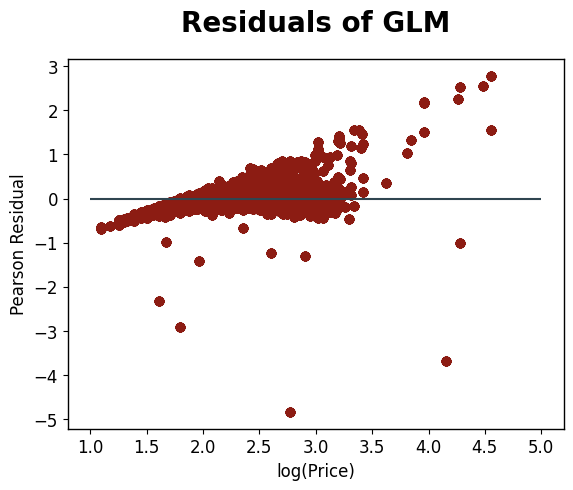

In [162]:
plt.scatter(pred_df["log_price"], fitted_glm.resid_pearson)
plt.hlines(y=0, xmin=1, xmax=5, color="#2F4550")
plt.xlabel("log(Price)")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()